<a href="https://colab.research.google.com/github/KaustavRaj/Text-Summarization/blob/master/Text_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Summarization
##### *by Kaustav Bhattacharjee, IIIT Guwahati*
---

In this notebook, I'm building a summarizer step-by-step, based on **Amazon Fine Food Reviews** dataset, which I have stored in **/data** section but it can also be found at kaggle website.

Let's first connect google colab to google drive, where I've saved my dataset.

In [0]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from bs4 import BeautifulSoup
from tensorflow.keras.layers import Bidirectional, LSTM, Input, Embedding, Dense, TimeDistributed, Concatenate, Attention
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
!pip install contractions

     |████████████████████████████████| 317kB 4.0MB/s 
     |████████████████████████████████| 245kB 47.4MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81703 sha256=c14986f4baea8a6d7a0d07f20cd924a90fb77cbceb3cddddd0fc19574dcca7bc
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [0]:
import contractions

In [0]:
dir_path = '/content/gdrive/My Drive/Colab Notebooks/Summarization/summarization v2'

## Dataset Loading & Cleaning

In [0]:
# Declaring the important variables here, which will be used later down the notebook

_NROWS           =   100000
_MAX_TEXT_LEN    =   0
_MAX_SUMMARY_LEN =   0
_TEXT_PADDING    =   'post'
_EMBEDDING_DIM   =   500
_ENCODER_DIM     =   300
_DECODER_DIM     =   600
_BATCH_SIZE      =   64
_EPOCHS          =   40

In [0]:
data = pd.read_csv(dir_path + '/data/Reviews.csv', nrows = _NROWS)
data.drop_duplicates(subset = ['Text'], inplace = True)
data.dropna(axis = 0, inplace = True)
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
def cleaner(text, remove_stopwords=True):
  """removes url's, nltk's stopwords and anything which is not an alphabet"""
  
  stop_words = set(stopwords.words('english'))
  text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text.lower(), flags=re.MULTILINE)
  text = re.sub(r'[^a-zA-Z]', ' ', text)
  text = contractions.fix(text, slang=False)
  if remove_stopwords:
    text = ' '.join([word for word in text.split() if word not in stop_words]).strip()
  return text

In [0]:
from time import time
from math import ceil

t1 = time()
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(cleaner(t))

t2 = time()
cleaned_summary = []
for t in data['Summary']:
    cleaned_summary.append(cleaner(t, remove_stopwords = False))

t3 = time()
print('Text cleaned in {} sec, and Summary in {} sec'.format(ceil(t2-t1), ceil(t3-t2)))

data = pd.DataFrame({
    'text'    :   cleaned_text,
    'summary' :   cleaned_summary})

data.replace('', np.nan, inplace = True)
data.dropna(axis = 0, inplace = True)

Text cleaned in 21 sec, and Summary in 15 sec


In [0]:
data.reset_index(inplace=True, drop=True)

In [0]:
data.shape

(88418, 2)

In [0]:
data.to_csv(dir_path + '/data/cleaned_amazon_reviews_dataset.csv', index=False)

## Visualizing the Text Data

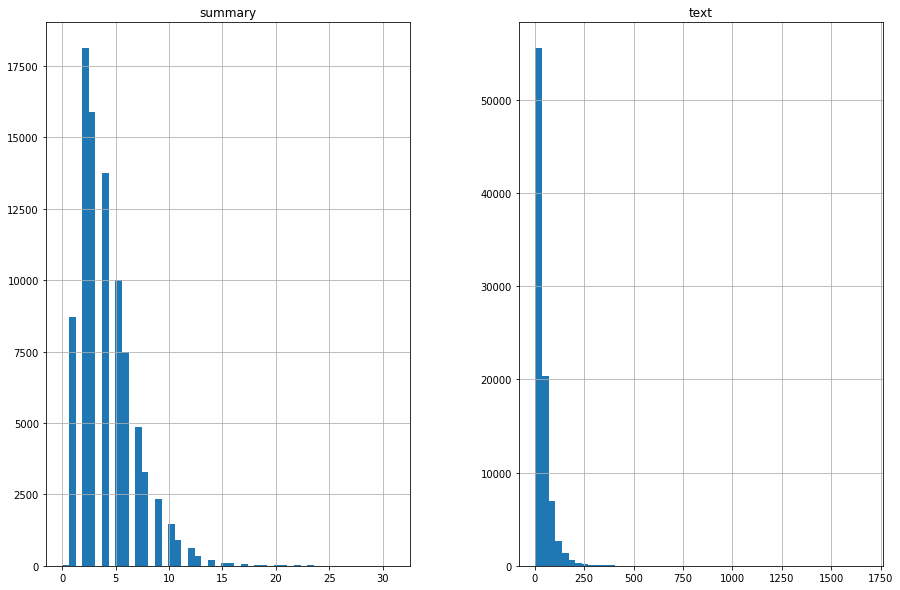

In [0]:
text_word_count    = []
summary_word_count = []

for i in data['text']:
      text_word_count.append(len(i.split()))

for i in data['summary']:
      summary_word_count.append(len(i.split()))

visualize = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
visualize.hist(bins = 50)
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [0]:
cnt = 0
for i in range(data.shape[0]):
  if len(data['text'][i].split()) <= 60 and len(data['summary'][i].split()) <= 10:
    cnt += 1
print(cnt)

70707


It's nearly 80% of our dataset, so its fairly decent in size as well.

In [0]:
_MAX_SUMMARY_LEN = 10
_MAX_TEXT_LEN    = 60

In [0]:
def prepare(dataset):
  global _MAX_SUMMARY_LEN, _MAX_TEXT_LEN
  newtext    =  []
  newsummary =  []
  
  for i in range(len(dataset['text'])):
    if len(dataset['text'][i].split()) <= _MAX_TEXT_LEN and len(dataset['summary'][i].split()) <= _MAX_SUMMARY_LEN:
      newtext.append(dataset['text'][i])
      newsummary.append(dataset['summary'][i])

  dataset = pd.DataFrame({'text'    : newtext,
                          'summary' : newsummary})
  dataset['summary'] = dataset['summary'].apply(lambda row : 'stok ' + row + ' etok')
  dataset.reset_index(drop=True, inplace=True)
  return dataset

In [0]:
df = prepare(data)

In [0]:
df.shape

(70707, 2)

In [0]:
df.to_csv(dir_path + '/data/prepared_amazon_reviews_dataset.csv', index=False)

## Training-Validation Data Splitting

Loading the data here if its already cleaned.

In [0]:
df = pd.read_csv(dir_path + '/data/prepared_amazon_reviews_dataset.csv')[['text', 'summary']]

In [0]:
df.head()

,text,summary
0,bought several vitality canned dog food produc...,stok good quality dog food etok
1,product arrived labeled jumbo salted peanuts p...,stok not as advertised etok
2,confection around centuries light pillowy citr...,stok delight says it all etok
3,looking secret ingredient robitussin believe f...,stok cough medicine etok
4,great taffy great price wide assortment yummy ...,stok great taffy etok


In [0]:
x_tr, x_val, y_tr, y_val = train_test_split(np.array(df['text']), np.array(df['summary']),
                                       test_size=0.1, random_state=42)

In [0]:
# preparing 'text' for model training and validation
tok_x  = Tokenizer()
tok_x.fit_on_texts(list(x_tr))
x_tr    =  pad_sequences(tok_x.texts_to_sequences(x_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
x_val   =  pad_sequences(tok_x.texts_to_sequences(x_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_x =  len(tok_x.word_counts) + 1

In [0]:
vocab_x

35209

In [0]:
# preparing 'summary' for model training and validation
tok_y  = Tokenizer()
tok_y.fit_on_texts(list(y_tr))
y_tr    =  pad_sequences(tok_y.texts_to_sequences(y_tr),  maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
y_val   =  pad_sequences(tok_y.texts_to_sequences(y_val), maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
vocab_y =  len(tok_y.word_counts) + 1

In [0]:
with open(dir_path + '/data/tok_x.pickle', 'wb') as f:
  pickle.dump(tok_x, f)

In [0]:
vocab_y

11876

In [0]:
tok_y.word_counts['stok'], len(y_tr)

(63636, 63636)

In [0]:
index_to_word_text    =  tok_x.index_word
index_to_word_summary =  tok_y.index_word
word_to_index_summary =  tok_y.word_index

In [0]:
import pickle
with open(dir_path + '/data/word_indices_mapping.pickle', 'wb') as f:
  store = [index_to_word_text, index_to_word_summary, word_to_index_summary]
  pickle.dump(store, f)

## Model Building

A simple Sequence to Sequence encoder-decoder model has been used, where a bidirectional lstm is used as encoder and a unidirectional lstm for decoder with attention layer.

In [0]:
# Encoder
encoder_input  =  Input(shape=(_MAX_TEXT_LEN,), name='Encoder_input')
encoder_embed  =  Embedding(vocab_x, _EMBEDDING_DIM, trainable=True, name='Encoder_embedding')(encoder_input)
encoder        =  Bidirectional(LSTM(_ENCODER_DIM, 
                                     return_sequences=True,
                                     return_state=True,
                                     dropout=0.4, recurrent_dropout=0.4), name='Encoder_layer')
encoder_output, forward_h, forward_c, backward_h, backward_c = encoder(encoder_embed)
state_h        =  Concatenate()([forward_h, backward_h])
state_c        =  Concatenate()([forward_c, backward_c])

# Decoder
decoder_input        =  Input(shape=(None,), name='Decoder_input')
decoder_embed_layer  =  Embedding(vocab_y, _EMBEDDING_DIM, trainable=True, name='Decoder_embedding')
decoder_embed        =  decoder_embed_layer(decoder_input)
decoder              =  LSTM(_DECODER_DIM,
                             return_sequences=True,
                             return_state=True,
                             dropout=0.4, recurrent_dropout=0.3, name='Decoder_layer')
decoder_output, decoder_state_h, decoder_state_c = decoder(decoder_embed,initial_state=[state_h, state_c])

# Attention layer
attention_layer =  Attention(name='Attention_layer')
attention_out   =  attention_layer([decoder_output, encoder_output])

# Concat attention layer's output and decoder's output
concat_layer    =  Concatenate(axis=-1, name='Concat_layer')([decoder_output, attention_out])

# Dense layer
decoder_dense   =  TimeDistributed(Dense(vocab_y, activation='softmax'))
decoder_output  =  decoder_dense(concat_layer)

# Model 
model           =  Model([encoder_input, decoder_input], decoder_output, name='Model')

model.summary()

Model: "Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Encoder_input (InputLayer)      [(None, 60)]         0                                            
__________________________________________________________________________________________________
Encoder_embedding (Embedding)   (None, 60, 500)      17604500    Encoder_input[0][0]              
__________________________________________________________________________________________________
Decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_layer (Bidirectional)   [(None, 60, 600), (N 1922400     Encoder_embedding[0][0]          
______________________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

stopearly =  EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
X         =  [x_tr,y_tr[:,:-1]]
y         =  y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:]
VAL_X     =  [x_val,y_val[:,:-1]]
VAL_y     =  y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]
history   =  model.fit(X, y, epochs=_EPOCHS, callbacks=[stopearly], batch_size=_BATCH_SIZE, validation_data=(VAL_X, VAL_y))

Train on 63636 samples, validate on 7071 samples
Epoch 1/40
63636/63636 [==============================] - 729s 11ms/sample - loss: 0.4785 - val_loss: 0.3771
Epoch 2/40
63636/63636 [==============================] - 723s 11ms/sample - loss: 0.3661 - val_loss: 0.3342
Epoch 3/40
63636/63636 [==============================] - 724s 11ms/sample - loss: 0.3234 - val_loss: 0.3150
Epoch 4/40
63636/63636 [==============================] - 724s 11ms/sample - loss: 0.2888 - val_loss: 0.3055
Epoch 5/40
63636/63636 [==============================] - 721s 11ms/sample - loss: 0.2570 - val_loss: 0.3044
Epoch 6/40
63636/63636 [==============================] - 724s 11ms/sample - loss: 0.2265 - val_loss: 0.3080
Epoch 7/40
63636/63636 [==============================] - 725s 11ms/sample - loss: 0.1982 - val_loss: 0.3145
Epoch 00007: early stopping


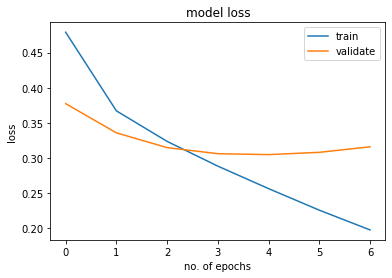

In [0]:
# For loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('no. of epochs')
plt.ylabel('loss')
plt.legend(['train', 'validate'], loc='upper right')
plt.show()

In [0]:
_MODEL_NAME = 'model_3'
model.save(dir_path + '/models/{}.h5'.format(_MODEL_NAME))

In [0]:
import json

specs = {
    'model_name' : _MODEL_NAME,
    'embedding_dim'  : _EMBEDDING_DIM,
    'encoder' : [{'type':'bi-LSTM', 'dim':_ENCODER_DIM}],
    'decoder' : [{'type':'LSTM', 'dim': _DECODER_DIM}],
    'attention' : {
        'used' : True,
        'type' : 'Luong'
    },
    'batch_size' : _BATCH_SIZE,
    'epochs_completed' : 7,
    'max_text_len' : _MAX_TEXT_LEN,
    'max_summary_len' : _MAX_SUMMARY_LEN,
    'nrows_dataset' : {
        'total' : 100000,
        'used' : 70707
    },
    'additional' : ""
}

with open(dir_path + '/models/specs3.json', 'a+') as f:
  json.dump(specs, f)

## Inference

In [0]:
encoder_model = Model(inputs  = encoder_input,
                outputs = [encoder_output, state_h, state_c])

# For storing decoder's previous states which will act as our encoder here
decoder_previous_state_h = Input(shape=(_DECODER_DIM,))
decoder_previous_state_c = Input(shape=(_DECODER_DIM,))
decoder_previous_output  = Input(shape=(_MAX_TEXT_LEN, _DECODER_DIM))

# This new decoder will take the 'previous decoder' i.e, our encoder's output
decoder_embed_new = decoder_embed_layer(decoder_input)
decoder_output_new, state_h_new, state_c_new = decoder(decoder_embed_new,
                                                       initial_state = [decoder_previous_state_h, decoder_previous_state_c])

# Attention layer & concat layer for the new decoder and encoder
attention_out_new    =  attention_layer([decoder_output_new, decoder_previous_output])
concat_layer_final   =  Concatenate(axis=-1)([decoder_output_new, attention_out_new])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_output_final =  decoder_dense(concat_layer_final)

# Final decoder model
decoder_model = Model(
    [decoder_input] + [decoder_previous_output, decoder_previous_state_h, decoder_previous_state_c],
    [decoder_output_final] + [state_h_new, state_c_new])

In [0]:
# saving encoder_model and decoder_model for later use

encoder_model.save(dir_path + '/models/encoder_model.h5')
decoder_model.save(dir_path + '/models/decoder_model.h5')

In [0]:
# Summarizes an input sequence to the final sequence by making the encoder-decoder model 
# predict 1 word at a time

def summarizer(input_seq):
    encoder_out, encoder_h, encoder_c = encoder_model.predict(input_seq)
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = word_to_index_summary['stok']
    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encoder_out, encoder_h, encoder_c])
        # Greedy decoder
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = index_to_word_summary[sampled_token_index]
        
        if sampled_token != 'etok':
            decoded_sentence += sampled_token + ' '

        if sampled_token == 'etok' or len(decoded_sentence.split()) >= (_MAX_SUMMARY_LEN-1):
            stop_condition = True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        encoder_h, encoder_c = h, c

    return decoded_sentence

In [0]:
def sequence_to_summary(input_seq):
    s = ''
    for i in input_seq:
        if i != 0 and i != word_to_index_summary['stok'] and i != word_to_index_summary['etok']:
            s += index_to_word_summary[i] + ' '
    return s

def sequence_to_text(input_seq):
    s = ''
    for i in input_seq:
        if i != 0:
            s += index_to_word_text[i] + ' '
    return s

Let's test it on a few examples from our dataset itself

First from the training dataset

In [0]:
for i in range(5):
    print("Review:",sequence_to_text(x_tr[i]))
    print("Original summary:",sequence_to_summary(y_tr[i]))
    print("Predicted summary:",summarizer(x_tr[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: purchased macha health food store figured best quality assuming bright color smell best good macha tea better opinion color darker smell stronger told going potent tried far gives great boost body likes well highly sensative put body happy feel made great choice company product plan buy future 
Original summary: better than expected 
Predicted summary: better than expected 


Review: health food low calorie alternatives disgusting smelled gross package first opened big deal follwed directions exactly wash noodles blanch boiling water cook sauteed soy sauce olive oil flavor ok really much flavor soaked soy sauce nicely texture however along lines poorly cooked calamari rubbery almost little slimy ew br br also know return grocery items amazon pretty much stuck buy 
Original summary: entirely inedible 
Predicted summary: entirely inedible 


Review: cat iron stomach eat absolutely anything everything always getting human food never thrown gave treats within minutes wheezing throw

Now from the validation dataset

In [0]:
for i in range(5):
    print("Review:",sequence_to_text(x_val[i]))
    print("Original summary:",sequence_to_summary(y_val[i]))
    print("Predicted summary:",summarizer(x_val[i].reshape(1,_MAX_TEXT_LEN)))
    print("\n")

Review: son loves asks sees package gets special treat want cereal puffs like less sugar protein popular brands 
Original summary: perfect treat for little ones 
Predicted summary: my son loves these 


Review: good service fabulous product fresh extremely well packed definitely order 
Original summary: blue diamond almonds 
Predicted summary: excellent 


Review: min pin snickers seems enjoy heck small treats perfect size tiny little mouth thank 
Original summary: dog treats lamb 
Predicted summary: great treats 


Review: original spearmint altoids flavor favorite flavor new improved version quite nasty comparison please bring back original spearmint flavor 
Original summary: fix spearmint altoids 
Predicted summary: worst flavor ever 


Review: must say quite disappointed product order purchased product years ago remembered full bodied flavorful perfect every respect like drinking perfect cup hot chocolate product bearing name yet much different packaging look measure earlier experi

So far so good, let's now build a wrapper function to try out any other sentence

In [0]:
def tryit(sent):
  """wrapper function to test the model"""

  sent = cleaner(sent, remove_stopwords=True)
  if len(sent.split()) > _MAX_TEXT_LEN:
    return "make your sentence length less than {} words".format(_MAX_TEXT_LEN)

  seq = tok_x.texts_to_sequences(sent.split())
  seq = [[item for sublist in seq for item in sublist]]
  seq = pad_sequences(seq, maxlen=_MAX_TEXT_LEN, padding=_TEXT_PADDING)
  return summarizer(seq.reshape(1,_MAX_TEXT_LEN))

Next comes to trying it out on a sentence. Let's see how it performs on the below text.

In [0]:
text = 'We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented. \
The waiters were attentive and service overall was good. The restaurant looked to have been recently decorated. \
Overall a good meal and great value we will certainly be going back.'

real_summary = 'tried megna good food attentive waiters'

In [0]:
tryit(text)

'great taste '

Not bad, since most of the amazon's dataset had similar summaries for such reviews. Now let's split each sentence and try that out.

In [0]:
text1 = text.split('.')
for l in text1:
  if len(l) > 0:
    print('text :', l.strip())
    print('predict:', tryit(l))
    print('\n')

text : We tried the Megna for the first time last night and the food was great, freshly cooked very tasty and well presented
predict: great taste 


text : The waiters were attentive and service overall was good
predict: good 


text : The restaurant looked to have been recently decorated
predict: great product 


text : Overall a good meal and great value we will certainly be going back
predict: good value 




It draws out the meaning atleast. Now let's try it out on more sentences.

In [0]:
tryit('my dog was delighted to eat meat chunks')

'dog loves it '

In [0]:
tryit('the food was terribly good')

'good stuff '

In [0]:
tryit('the food was terrible')

'terrible '

In [0]:
tryit('the food was good but bad')

'good stuff '

In [0]:
tryit('the food was bad at first but finally it turned out to be otherwise')

'not my favorite '

In [0]:
tryit('I love maggi but couldn\'t find any')

'love it '

In [0]:
tryit('well to be honest the customer service is not good')

'great service '

In [0]:
tryit('bad food')

'not bad '

In [0]:
tryit('well the food was not that bad but certainly can be improved')

'not that great '

Well, its working quite well except for a few sentences which has a big deeper meaning or usage of both words such as 'good' and 'bad', although it gave correct answer for second sentence despite having both 'terrible' and 'good' used together.

## Conclusion

The Model is working out well but it has some flaws as mentioned above. More improvements can be done to ensure better accuracy.